In [1]:
## This notebook will 
# 1) artificially generate outliers for imported time series data
# 2) generate vizualizations and metrics for characterizing outliers
# 3) randomly insert the outliers into the data
# 4) apply callsification methods from: scikit to detect artificial outliers
# 5) apply classification methods from: tensorflow to detect artificial outliers
# 6) apply forecastin as third analysis with confidence intervals
# https://scikit-learn.org/dev/auto_examples/plot_anomaly_comparison.html
# https://github.com/RobRomijnders/AE_ts

# primarily interested in the body 'Temp' (Celcius) variable to add outliers.
# this could be interpretted as a fever.
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt
import random


In [2]:
## import data
fdir = "C:/Users/..."
file  = "time_series.xlsx"
#print(pd.ExcelFile(fdir + '/' + file).sheet_names)
#returns xlsx list of sheet names

dataraw = pd.read_excel(fdir + '/' + file, sheet_name="data", usecols=[2,4])
dataraw["Time"] = ((dataraw["Time"]/1000)/60)/60

# data with last 5 points truncated since visual inspection shows some corruption
dataclean = dataraw[:-5].copy().dropna()

# lastly the time-series is edited to contain artificially inserted outliers
# 0.3% (3 std) of the cleaned data are replaced with values above/below 3 standard deviations of the mean raw data
outliers_fraction = .003 
#fraction of normal distribution that accounts for 3, 4, 5 stds is 0.003, 0.00006, 0.0000006, respectively
n_outliers = int(outliers_fraction*dataclean.describe().loc["count","Temp"])
# create list of indexes to modify
index_outliers = pd.DataFrame(random.sample(range(0,int(dataclean.describe().loc["count","Temp"]+1)), n_outliers) )

dataclean_mean = float(dataclean.describe().loc["mean","Temp"])
dataclean_std = float(dataclean.describe().loc["std","Temp"])
print(dataclean_mean, dataclean_std)

#insert random datapoints
std_factor = 5 #multiplier factor to determine anomalous value range from instantaneous temp
random.seed(18)
datadirty = dataclean.copy()
for i, row in index_outliers.iterrows():
	point_temp = float(dataclean.loc[row,"Temp"])
	# if point_temp >= dataclean_mean:
	dirty_temp = point_temp + ((random.random() - 0.5)*2*dataclean_std*std_factor)
	# if point_temp < dataclean_mean:
	# 	dirty_temp = point_temp - (random.random()*dataclean_std*4)
	datadirty.at[row,"Temp"] = dirty_temp

print(datadirty.describe())
datasets = pd.DataFrame()
#datasets["Raw Time Series"] = dataraw["Temp"]
datasets["Clean Time Series"] = dataclean["Temp"]
datasets["Dirty Time Series"] = datadirty["Temp"]

34.987330590309845 0.9734180471067855
                Time          Temp
count   59545.000000  59545.000000
mean   425384.380849     34.987853
std        19.871564      0.984214
min    425350.683696     27.997768
25%    425367.223696     34.500000
50%    425383.763696     35.300000
75%    425401.747030     35.600000
max    425419.067030     40.218485


In [3]:
## initialize and set outlier detection method from scikit-learn:
# This was initially set up to loop through a number of useful anomalous boundary classifiers

algorithms = [("Local Outlier Factor", LocalOutlierFactor(n_neighbors=10, contamination=outliers_fraction))]
#			("Isolation Forest", IsolationForest(behaviour='new', contamination=outliers_fraction, random_state=180))]
time_min = float(dataclean.describe().loc["min","Time"])

Clean Time Series
<class 'numpy.ndarray'>
[[33.4]
 [32.4]
 [32.4]
 ...
 [34.8]
 [34.8]
 [34.5]]
Dirty Time Series
<class 'numpy.ndarray'>
[[33.4]
 [32.4]
 [32.4]
 ...
 [34.8]
 [34.8]
 [34.5]]


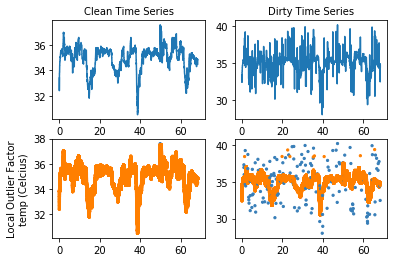

In [4]:
# Generate plots

# raw plot
plt.subplot(2,2,1)
plt.plot(dataclean["Time"]-time_min,dataclean["Temp"])
plt.title("Clean Time Series", size=10)
plt.xlabel('time (seconds)')

# anomalous
plt.subplot(2,2,2)
plt.plot(datadirty["Time"]-time_min,datadirty["Temp"])
plt.title("Dirty Time Series", size=10)
plt.xlabel('time (seconds)')

len_dataraw = dataraw.describe().loc["count","Temp"]
max_datadirty = datadirty.describe().loc["max", "Temp"]
min_datadirty = datadirty.describe().loc["min", "Temp"]

#apply algorithm to each dataset
plot_num = 3
for dataset in datasets:
	print(dataset)
	data = np.ravel(datasets[dataset]).reshape(-1,1)[~np.isnan(datasets[dataset])]
	print(type(data))
	print(data)
	data = data
	for name_algorithm, algorithm in algorithms:
		# fit data and label outliers
		if name_algorithm == "Local Outlier Factor":
			y_pred = algorithm.fit_predict(data)
		else:
			y_pred = algorithm.fit(dataset).predict(dataset)

		# if name_algorithm != "Local Outlier Factor":
		# 	Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])
		# 	Z = Z.reshape(xx.shape)
		# 	plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')
		if dataset == "Raw Time Series":
			x = dataraw["Time"]
		else:
			x = dataclean["Time"]
		colors = np.array(['#377eb8', '#ff7f00'])
		plt.subplot(2,2,plot_num)
		plt.scatter(x-time_min, data, s=5, color=colors[(y_pred + 1) // 2])
		if plot_num == 3 or plot_num == 5 or plot_num == 7:
			#plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[(y_pred + 1) // 2])
			plt.ylabel(name_algorithm+'\n'+'temp (Celcius)')


		plot_num += 1
plt.show()